<a href="https://colab.research.google.com/github/V-Sekai-fire/meshgpt-pytorch/blob/main/MeshGPT_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We use a local runtime. https://research.google.com/colaboratory/local-runtimes.html

In [24]:
#!bash <(curl -L micro.mamba.pm/install.sh) 
#Prefix location? [~/micromamba] /workspace/micromamba
#!pip3 install notebook jupyterlab
#!micromamba create -n py311_meshgpt python=3.11 anaconda -c pytorch -c conda-forge -c anaconda -c defaults -y
#!micromamba activate py311_meshgpt
#!jupyter notebook --port=9999  --NotebookApp.port_retries=0 --allow-root
# Login with kernel
!pip3 install git+https://github.com/MarcusLoppe/classifier-free-guidance-pytorch.git
!pip3 install git+https://github.com/MarcusLoppe/meshgpt-pytorch.git
!pip3 install trimesh

  Cloning https://github.com/MarcusLoppe/classifier-free-guidance-pytorch.git to /tmp/pip-req-build-k11vcwtf
  Running command git clone --filter=blob:none --quiet https://github.com/MarcusLoppe/classifier-free-guidance-pytorch.git /tmp/pip-req-build-k11vcwtf
  Resolved https://github.com/MarcusLoppe/classifier-free-guidance-pytorch.git to commit 698c83562f8859c763880f200b210ff1081efedc
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/MarcusLoppe/meshgpt-pytorch.git to /tmp/pip-req-build-pxyk2f_w
  Running command git clone --filter=blob:none --quiet https://github.com/MarcusLoppe/meshgpt-pytorch.git /tmp/pip-req-build-pxyk2f_w
  Resolved https://github.com/MarcusLoppe/meshgpt-pytorch.git to commit d35228edc46b550dc8faeefb832db7bd43a23c2a
  Preparing metadata (setup.py) ... done


In [25]:
from re import T
is_train_autoencoder = True
is_train_autoencoder_disable_iteration = True
is_train_mesh_transformer = True
is_clear_dataset_npz = True


In [26]:
import torch
import trimesh
import numpy as np
import os
import csv
from collections import OrderedDict

from meshgpt_pytorch import (
    MeshTransformerTrainer,
    MeshAutoencoderTrainer,
    MeshAutoencoder,
    MeshTransformer
)
from meshgpt_pytorch.data import (
    derive_face_edges_from_faces
)

In [27]:
import trimesh
import torch
import numpy as np
import os
from collections import OrderedDict

max_faces = 4096

def get_mesh(file_path):
    mesh = trimesh.load(file_path, force='mesh')

    # Center and scale vertices
    center = np.mean(mesh.vertices, axis=0)
    vertices = mesh.vertices - center
    max_abs = np.max(np.abs(vertices))
    scale_factor = (1 / 128) / max_abs
    vertices *= scale_factor

    # Quantize vertices
    vertices = np.around(vertices).astype(np.float32)

    # Sort vertices by Z, Y, X
    sorted_indices = np.lexsort(vertices.T[::-1])
    vertices = vertices[sorted_indices]

    # Map old indices to new, sorted indices
    vertex_map = np.empty(len(sorted_indices), dtype=int)
    vertex_map[sorted_indices] = np.arange(len(sorted_indices))

    # Reindex faces
    reindexed_faces = vertex_map[mesh.faces]
    sorted_faces = np.sort(reindexed_faces, axis=1)

    return vertices, sorted_faces

def augment_mesh(vertices, jitter_strength=0.01):
    jitter_amount = np.random.uniform(-jitter_strength, jitter_strength, size=vertices.shape)
    vertices += jitter_amount
    return vertices

def snake_to_sentence_case(snake_str):
    components = snake_str.split("_")
    return " ".join(word.capitalize() for word in components)

def load_filename(directory, variations):
    obj_datas = []

    # Get random scale factors within a range
    scale_factors = np.random.uniform(0.75, 1.0, size=variations)

    for filename in os.listdir(directory):
        if filename.endswith(".glb"):
            file_path = os.path.join(directory, filename)
            vertices, faces = get_mesh(file_path)

            if len(faces) > max_faces:
                print(f"Mesh {filename} has {len(faces)} faces which is more than the allowed {max_faces} faces. Rejecting.")
                continue

            faces_tensor = torch.tensor(faces, dtype=torch.long).to("cuda")
            face_edges = derive_face_edges_from_faces(faces_tensor)

            text, _ = os.path.splitext(filename)
            text = snake_to_sentence_case(text)
            # Run video llava on the image. "Describe the focus of the photo as a json dictionary."
            for scale_factor in scale_factors:
                aug_vertices = augment_mesh(vertices.copy()) * scale_factor
                aug_vertices_tensor = torch.tensor(aug_vertices, dtype=torch.float)

            obj_data = {
                "vertices": aug_vertices_tensor.to("cuda"),
                "faces": faces_tensor,
                "face_edges": face_edges,
                "texts": text
            }
            obj_datas.append(obj_data)

    print(f"[create_mesh_dataset] Returning {len(obj_datas)} meshes")
    return obj_datas


In [28]:
from pathlib import Path
import gc
import torch
import os
from meshgpt_pytorch import MeshDataset

torch.cuda.empty_cache()
gc.collect()

working_dir = f'/workspace/meshgpt-pytorch/dataset/blockmesh_test'

working_dir = Path(working_dir)
working_dir.mkdir(exist_ok = True, parents = True)
dataset_path = working_dir / (project_name + ".npz")


if is_clear_dataset_npz:
    data = load_filename(working_dir, 1)
    dataset = MeshDataset(data)
    dataset.generate_face_edges()
    dataset.save(dataset_path)
else:
    dataset = MeshDataset.load(dataset_path)

Mesh s_chair_office.glb has 6894 faces which is more than the allowed 4096 faces. Rejecting.
Mesh s_chair_office_01.glb has 25192 faces which is more than the allowed 4096 faces. Rejecting.
Mesh s_desk.glb has 7240 faces which is more than the allowed 4096 faces. Rejecting.
Mesh s_door_double.glb has 4424 faces which is more than the allowed 4096 faces. Rejecting.
Mesh s_form_torso_dress_feminine.glb has 21754 faces which is more than the allowed 4096 faces. Rejecting.
Mesh s_sgcontroller.glb has 8848 faces which is more than the allowed 4096 faces. Rejecting.
Mesh s_skate_park.glb has 8598 faces which is more than the allowed 4096 faces. Rejecting.
Mesh s_table_coffee.glb has 4304 faces which is more than the allowed 4096 faces. Rejecting.
Mesh s_table_coffee_variation.glb has 8140 faces which is more than the allowed 4096 faces. Rejecting.
Mesh s_vehicle_bicycle_bmx.glb has 39972 faces which is more than the allowed 4096 faces. Rejecting.
Mesh sk_baby_01.glb has 13408 faces which is 

### Inspect

In [29]:
seen_texts = []
mesh_list = []  # List to store individual meshes
translation_distance = 1.0  # Distance to translate vertices, set to 1 unit as required

# Iterate over each item in the dataset
for r, item in enumerate(dataset.data):
    # Get vertices and faces
    vertices = np.array(item['vertices'].cpu())
    faces = np.array(item['faces'].cpu())
    texts = item['texts']

    if texts in seen_texts:
      continue
    seen_texts.append(texts)

    # Translate the vertices copy
    translation_vector = np.array([len(seen_texts) * translation_distance, 0, 0])  # Translation along the x-axis
    vertices[:, :3] += translation_vector  # Apply translation only to x, y, z

    # Create a new mesh object with the translated vertices and original faces
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

    # Append the new mesh to our list of meshes
    mesh_list.append(mesh)

    print(f"Iteration {r} complete. Processed texts {texts} with {len(vertices)} vertices and {len(faces)} faces.")

# After iterating over all items, print the number of processed meshes
print(f"Total number of processed meshes: {len(mesh_list)}")


Iteration 0 complete. Processed texts Mire Clothing with 2179 vertices and 3884 faces.
Iteration 1 complete. Processed texts S Bed Full with 62 vertices and 48 faces.
Iteration 2 complete. Processed texts S Bed King with 403 vertices and 480 faces.
Iteration 3 complete. Processed texts S Bed Twin with 403 vertices and 480 faces.
Iteration 4 complete. Processed texts S Bone with 56 vertices and 24 faces.
Iteration 5 complete. Processed texts S Box with 24 vertices and 12 faces.
Iteration 6 complete. Processed texts S Cabinet Bookshelf with 690 vertices and 512 faces.
Iteration 7 complete. Processed texts S Cabinet Dresser 03 with 552 vertices and 256 faces.
Iteration 8 complete. Processed texts S Cabinet Dresser 05 with 744 vertices and 344 faces.
Iteration 9 complete. Processed texts S Chair Bar with 385 vertices and 440 faces.
Iteration 10 complete. Processed texts S Chair Box with 1848 vertices and 912 faces.
Iteration 11 complete. Processed texts S Chair Modern with 904 vertices and

### Train!

In [30]:
autoencoder = MeshAutoencoder().to("cuda")

**Have at least 400-2000 items in the dataset, use this to multiply the dataset**  

In [31]:
import random


random.seed(42)
random.shuffle(dataset.data)

initial_length = len(dataset.data)
target_length = 2000
print(initial_length)
if initial_length > 0:
    replication_factor = max(1, (target_length - 1) // initial_length + 1)
    dataset.data *= replication_factor
    dataset.data = dataset.data[:target_length]

print(len(dataset.data))

44
2000


**Train to about 0.3 loss if you are using a small dataset**

Epoch 1/380:   0%|                                                                                                                                                     | 0/250 [00:00<?, ?it/s]

Epoch 1/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:51<00:00,  4.83it/s, commit_loss=0.538, loss=0.921, recon_loss=0.867]


Epoch 1 average loss: 1.0335369660854339 recon loss: 0.9772: commit_loss 0.5633


Epoch 2/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.23it/s, commit_loss=0.543, loss=0.763, recon_loss=0.709]


Epoch 2 average loss: 0.8711508121490479 recon loss: 0.8294: commit_loss 0.4174


Epoch 3/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:48<00:00,  5.19it/s, commit_loss=0.111, loss=0.503, recon_loss=0.492]


Epoch 3 average loss: 0.6664232909679413 recon loss: 0.6501: commit_loss 0.1630


Epoch 4/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.25it/s, commit_loss=-0.0215, loss=0.34, recon_loss=0.343]


Epoch 4 average loss: 0.37516917049884796 recon loss: 0.3664: commit_loss 0.0872          avg loss speed: 0.48186785256862635


Epoch 5/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.24it/s, commit_loss=0.152, loss=0.356, recon_loss=0.341]


Epoch 5 average loss: 0.34093191277980806 recon loss: 0.3416: commit_loss -0.0068          avg loss speed: 0.296649178425471


Epoch 6/380: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.28it/s, commit_loss=0.0262, loss=0.342, recon_loss=0.34]


Epoch 6 average loss: 0.3280188950300217 recon loss: 0.3403: commit_loss -0.1223          avg loss speed: 0.13282256305217743 epochs left: 0.21


Epoch 7/380: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.33it/s, commit_loss=-0.145, loss=0.324, recon_loss=0.339]


Epoch 7 average loss: 0.3193538988828659 recon loss: 0.3392: commit_loss -0.1984          avg loss speed: 0.028686093886693353 epochs left: 0.67


Epoch 8/380: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.28it/s, commit_loss=-0.253, loss=0.312, recon_loss=0.338]


Epoch 8 average loss: 0.31170166516304015 recon loss: 0.3381: commit_loss -0.2644          avg loss speed: 0.0177332370678584 epochs left: 0.66


Epoch 9/380: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.22it/s, commit_loss=-0.351, loss=0.302, recon_loss=0.337]


Epoch 9 average loss: 0.3048476107120514 recon loss: 0.3375: commit_loss -0.3264          avg loss speed: 0.014843875646591176 epochs left: 0.33


Epoch 10/380: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.28it/s, commit_loss=-0.466, loss=0.29, recon_loss=0.337]


Epoch 10 average loss: 0.29932050371170044 recon loss: 0.3371: commit_loss -0.3780          avg loss speed: 0.012647221207618742 epochs left: 0.05


Epoch 11/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.33it/s, commit_loss=-0.338, loss=0.303, recon_loss=0.337]


Epoch 11 average loss: 0.29405574053525924 recon loss: 0.3370: commit_loss -0.4295          avg loss speed: 0.01123418599367143 epochs left: 0.53


Epoch 12/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.34it/s, commit_loss=-0.447, loss=0.292, recon_loss=0.337]


Epoch 12 average loss: 0.29043696296215055 recon loss: 0.3369: commit_loss -0.4648          avg loss speed: 0.008970988690853166 epochs left: 1.07


Epoch 13/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.35it/s, commit_loss=-0.362, loss=0.301, recon_loss=0.337]


Epoch 13 average loss: 0.2884493005275726 recon loss: 0.3369: commit_loss -0.4845          avg loss speed: 0.006155101875464142 epochs left: 1.88


Epoch 14/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:48<00:00,  5.20it/s, commit_loss=-0.289, loss=0.308, recon_loss=0.337]


Epoch 14 average loss: 0.2879148007631302 recon loss: 0.3369: commit_loss -0.4896          avg loss speed: 0.003065867245197307 epochs left: 3.94


Epoch 15/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.30it/s, commit_loss=-0.186, loss=0.318, recon_loss=0.337]


Epoch 15 average loss: 0.2855890984535217 recon loss: 0.3368: commit_loss -0.5122          avg loss speed: 0.0033445896307627843 epochs left: 4.31


Epoch 16/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.30it/s, commit_loss=-0.345, loss=0.302, recon_loss=0.337]


Epoch 16 average loss: 0.28514472818374637 recon loss: 0.3368: commit_loss -0.5168          avg loss speed: 0.002173005064328437 epochs left: 6.84


Epoch 17/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.27it/s, commit_loss=-0.479, loss=0.289, recon_loss=0.337]


Epoch 17 average loss: 0.2844212913513184 recon loss: 0.3368: commit_loss -0.5238          avg loss speed: 0.001794917782147687 epochs left: 8.68


Epoch 18/380: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.29it/s, commit_loss=-0.51, loss=0.286, recon_loss=0.337]


Epoch 18 average loss: 0.2841107832789421 recon loss: 0.3368: commit_loss -0.5265          avg loss speed: 0.0009409227172533785 epochs left: 16.89


Epoch 19/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.25it/s, commit_loss=-0.495, loss=0.287, recon_loss=0.337]


Epoch 19 average loss: 0.2841419399380684 recon loss: 0.3368: commit_loss -0.5261          avg loss speed: 0.0004169943332671955 epochs left: 38.03


Epoch 20/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.30it/s, commit_loss=-0.619, loss=0.275, recon_loss=0.337]


Epoch 20 average loss: 0.28342174863815306 recon loss: 0.3367: commit_loss -0.5333          avg loss speed: 0.0008029228846232472 epochs left: 20.65


Epoch 21/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.33it/s, commit_loss=-0.635, loss=0.273, recon_loss=0.337]


Epoch 21 average loss: 0.2835773213505745 recon loss: 0.3368: commit_loss -0.5318          avg loss speed: 0.00031416926781335786 epochs left: 52.27


Epoch 22/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.31it/s, commit_loss=-0.461, loss=0.291, recon_loss=0.337]


Epoch 22 average loss: 0.28362838870286944 recon loss: 0.3367: commit_loss -0.5310          avg loss speed: 8.52812727292207e-05 epochs left: 191.97


Epoch 23/380: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.29it/s, commit_loss=-0.468, loss=0.29, recon_loss=0.337]


Epoch 23 average loss: 0.2840714508295059 recon loss: 0.3367: commit_loss -0.5265          avg loss speed: -0.0005289645989736136


Epoch 24/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.27it/s, commit_loss=-0.404, loss=0.296, recon_loss=0.337]


Epoch 24 average loss: 0.2834441388845444 recon loss: 0.3367: commit_loss -0.5327          avg loss speed: 0.00031491474310557654 epochs left: 52.57


Epoch 25/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.25it/s, commit_loss=-0.705, loss=0.266, recon_loss=0.337]


Epoch 25 average loss: 0.28360470885038375 recon loss: 0.3367: commit_loss -0.5312          avg loss speed: 0.00010995062192281635 epochs left: 149.12


Epoch 26/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.28it/s, commit_loss=-0.618, loss=0.275, recon_loss=0.337]


Epoch 26 average loss: 0.2836613384485245 recon loss: 0.3367: commit_loss -0.5305          avg loss speed: 4.5427739620185204e-05 epochs left: 359.66


Epoch 27/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:45<00:00,  5.45it/s, commit_loss=-0.657, loss=0.271, recon_loss=0.337]


Epoch 27 average loss: 0.28202553951740267 recon loss: 0.3367: commit_loss -0.5468          avg loss speed: 0.0015445225437482057 epochs left: 11.64


Epoch 28/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.31it/s, commit_loss=-0.522, loss=0.285, recon_loss=0.337]


Epoch 28 average loss: 0.28333457458019257 recon loss: 0.3367: commit_loss -0.5337          avg loss speed: -0.00023737897475561986


Epoch 29/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.26it/s, commit_loss=-0.614, loss=0.275, recon_loss=0.337]


Epoch 29 average loss: 0.28376300966739654 recon loss: 0.3367: commit_loss -0.5294          avg loss speed: -0.0007558588186899473


Epoch 30/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.36it/s, commit_loss=-0.776, loss=0.259, recon_loss=0.337]


Epoch 30 average loss: 0.2834548466205597 recon loss: 0.3367: commit_loss -0.5325          avg loss speed: -0.0004138053655624585


Epoch 31/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.26it/s, commit_loss=-0.588, loss=0.278, recon_loss=0.337]


Epoch 31 average loss: 0.28384722185134886 recon loss: 0.3367: commit_loss -0.5287          avg loss speed: -0.00032974489529924433


Epoch 32/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.23it/s, commit_loss=-0.389, loss=0.298, recon_loss=0.337]


Epoch 32 average loss: 0.28369372797012327 recon loss: 0.3367: commit_loss -0.5303          avg loss speed: -5.368590354937197e-06


Epoch 33/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.26it/s, commit_loss=-0.278, loss=0.309, recon_loss=0.337]


Epoch 33 average loss: 0.2837877823710442 recon loss: 0.3367: commit_loss -0.5291          avg loss speed: -0.00012251689036690827


Epoch 34/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.42it/s, commit_loss=-0.596, loss=0.277, recon_loss=0.337]


Epoch 34 average loss: 0.2816058045625687 recon loss: 0.3367: commit_loss -0.5509          avg loss speed: 0.002170439501603394 epochs left: 8.47


Epoch 35/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.30it/s, commit_loss=-0.634, loss=0.273, recon_loss=0.337]


Epoch 35 average loss: 0.28290572768449784 recon loss: 0.3367: commit_loss -0.5379          avg loss speed: 0.0001233772834142166 epochs left: 138.55


Epoch 36/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.32it/s, commit_loss=-0.846, loss=0.252, recon_loss=0.337]


Epoch 36 average loss: 0.2833122429251671 recon loss: 0.3367: commit_loss -0.5338          avg loss speed: -0.0005458047191301829


Epoch 37/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.40it/s, commit_loss=-0.556, loss=0.281, recon_loss=0.337]


Epoch 37 average loss: 0.2830728379487991 recon loss: 0.3367: commit_loss -0.5362          avg loss speed: -0.00046491289138789194


Epoch 38/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.32it/s, commit_loss=-0.844, loss=0.252, recon_loss=0.337]


Epoch 38 average loss: 0.2830639358758926 recon loss: 0.3367: commit_loss -0.5363          avg loss speed: 3.300031026204353e-05 epochs left: 513.21


Epoch 39/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:48<00:00,  5.20it/s, commit_loss=-0.446, loss=0.292, recon_loss=0.337]


Epoch 39 average loss: 0.2839606935977936 recon loss: 0.3367: commit_loss -0.5273          avg loss speed: -0.0008110213478406125


Epoch 40/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.35it/s, commit_loss=-0.689, loss=0.268, recon_loss=0.337]


Epoch 40 average loss: 0.2825638457536697 recon loss: 0.3367: commit_loss -0.5412          avg loss speed: 0.0008019767204920369 epochs left: 21.74


Epoch 41/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.31it/s, commit_loss=-0.737, loss=0.263, recon_loss=0.337]


Epoch 41 average loss: 0.2818541567325592 recon loss: 0.3367: commit_loss -0.5483          avg loss speed: 0.0013420016765594567 epochs left: 13.52


Epoch 42/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.31it/s, commit_loss=-0.826, loss=0.254, recon_loss=0.337]


Epoch 42 average loss: 0.2824570258259773 recon loss: 0.3367: commit_loss -0.5423          avg loss speed: 0.0003358728686968515 epochs left: 52.23


Epoch 43/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.30it/s, commit_loss=-0.482, loss=0.289, recon_loss=0.337]


Epoch 43 average loss: 0.28312391984462737 recon loss: 0.3367: commit_loss -0.5356          avg loss speed: -0.0008322437405586247


Epoch 44/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.25it/s, commit_loss=-0.879, loss=0.249, recon_loss=0.337]


Epoch 44 average loss: 0.28321936666965486 recon loss: 0.3367: commit_loss -0.5346          avg loss speed: -0.0007409992019335454


Epoch 45/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.30it/s, commit_loss=-0.593, loss=0.277, recon_loss=0.337]


Epoch 45 average loss: 0.2831628223657608 recon loss: 0.3367: commit_loss -0.5352          avg loss speed: -0.0002293849190075914


Epoch 46/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.27it/s, commit_loss=-0.552, loss=0.281, recon_loss=0.337]


Epoch 46 average loss: 0.28292904353141785 recon loss: 0.3367: commit_loss -0.5375          avg loss speed: 0.0002396594285964948 epochs left: 71.23


Epoch 47/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.29it/s, commit_loss=-0.491, loss=0.288, recon_loss=0.337]


Epoch 47 average loss: 0.2831520767211914 recon loss: 0.3367: commit_loss -0.5353          avg loss speed: -4.8332532246897486e-05


Epoch 48/380: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.32it/s, commit_loss=-0.662, loss=0.27, recon_loss=0.337]


Epoch 48 average loss: 0.2818082211613655 recon loss: 0.3367: commit_loss -0.5487          avg loss speed: 0.0012730930447578115 epochs left: 14.29


Epoch 49/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.29it/s, commit_loss=-0.738, loss=0.263, recon_loss=0.337]


Epoch 49 average loss: 0.2830018575191498 recon loss: 0.3367: commit_loss -0.5368          avg loss speed: -0.0003720770478248814


Epoch 50/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.36it/s, commit_loss=-0.437, loss=0.293, recon_loss=0.337]


Epoch 50 average loss: 0.2825687620043755 recon loss: 0.3367: commit_loss -0.5411          avg loss speed: 8.528979619343291e-05 epochs left: 204.38


Epoch 51/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.35it/s, commit_loss=-0.561, loss=0.281, recon_loss=0.337]


Epoch 51 average loss: 0.28281522941589354 recon loss: 0.3367: commit_loss -0.5386          avg loss speed: -0.00035561585426330256


Epoch 52/380: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.30it/s, commit_loss=-0.563, loss=0.28, recon_loss=0.337]


Epoch 52 average loss: 0.2831529085636139 recon loss: 0.3367: commit_loss -0.5353          avg loss speed: -0.0003576255838076414


Epoch 53/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.30it/s, commit_loss=-0.314, loss=0.305, recon_loss=0.337]


Epoch 53 average loss: 0.28251574313640593 recon loss: 0.3367: commit_loss -0.5416          avg loss speed: 0.00032989019155504895 epochs left: 53.00


Epoch 54/380: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.25it/s, commit_loss=-0.467, loss=0.29, recon_loss=0.337]


Epoch 54 average loss: 0.2829220789670944 recon loss: 0.3367: commit_loss -0.5376          avg loss speed: -9.411859512331588e-05


Epoch 55/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.33it/s, commit_loss=-0.546, loss=0.282, recon_loss=0.337]


Epoch 55 average loss: 0.2820502272248268 recon loss: 0.3367: commit_loss -0.5463          avg loss speed: 0.0008133496642112603 epochs left: 22.07


Epoch 56/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.26it/s, commit_loss=-0.552, loss=0.282, recon_loss=0.337]


Epoch 56 average loss: 0.28273614299297334 recon loss: 0.3367: commit_loss -0.5394          avg loss speed: -0.00024012655019761686


Epoch 57/380: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.25it/s, commit_loss=-0.466, loss=0.29, recon_loss=0.337]


Epoch 57 average loss: 0.2827775812745094 recon loss: 0.3367: commit_loss -0.5390          avg loss speed: -0.0002080982128779274


Epoch 58/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.35it/s, commit_loss=-0.292, loss=0.307, recon_loss=0.337]


Epoch 58 average loss: 0.2826230196356773 recon loss: 0.3367: commit_loss -0.5406          avg loss speed: -0.0001017024715740944


Epoch 59/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.25it/s, commit_loss=-0.337, loss=0.303, recon_loss=0.337]


Epoch 59 average loss: 0.28301085996627806 recon loss: 0.3367: commit_loss -0.5367          avg loss speed: -0.00029861199855801823


Epoch 60/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.28it/s, commit_loss=-0.539, loss=0.283, recon_loss=0.337]


Epoch 60 average loss: 0.28255808985233305 recon loss: 0.3367: commit_loss -0.5412          avg loss speed: 0.0002457304398219007 epochs left: 70.98


Epoch 61/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.37it/s, commit_loss=-0.489, loss=0.288, recon_loss=0.337]


Epoch 61 average loss: 0.28103923004865644 recon loss: 0.3367: commit_loss -0.5563          avg loss speed: 0.0016914264361063136 epochs left: 11.21


Epoch 62/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.26it/s, commit_loss=-0.404, loss=0.296, recon_loss=0.337]


Epoch 62 average loss: 0.2826628521084785 recon loss: 0.3367: commit_loss -0.5401          avg loss speed: -0.00046012548605600667


Epoch 63/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.30it/s, commit_loss=-0.681, loss=0.269, recon_loss=0.337]


Epoch 63 average loss: 0.2828120095729828 recon loss: 0.3367: commit_loss -0.5386          avg loss speed: -0.0007252855698268168


Epoch 64/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.28it/s, commit_loss=-0.504, loss=0.286, recon_loss=0.337]


Epoch 64 average loss: 0.2827661285400391 recon loss: 0.3367: commit_loss -0.5391          avg loss speed: -0.0005947646299998


Epoch 65/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.23it/s, commit_loss=-0.343, loss=0.302, recon_loss=0.337]


Epoch 65 average loss: 0.28236752897500994 recon loss: 0.3367: commit_loss -0.5430          avg loss speed: 0.00037946776549019345 epochs left: 46.47


Epoch 66/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.32it/s, commit_loss=-0.632, loss=0.274, recon_loss=0.337]


Epoch 66 average loss: 0.2819991796016693 recon loss: 0.3367: commit_loss -0.5467          avg loss speed: 0.0006493760943412918 epochs left: 27.72


Epoch 67/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.32it/s, commit_loss=-0.634, loss=0.273, recon_loss=0.337]


Epoch 67 average loss: 0.2823806851506233 recon loss: 0.3367: commit_loss -0.5429          avg loss speed: -3.0727783839057388e-06


Epoch 68/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.33it/s, commit_loss=-0.645, loss=0.272, recon_loss=0.337]


Epoch 68 average loss: 0.282094863653183 recon loss: 0.3367: commit_loss -0.5458          avg loss speed: 0.0001542675892511891 epochs left: 116.07


Epoch 69/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.30it/s, commit_loss=-0.542, loss=0.283, recon_loss=0.337]


Epoch 69 average loss: 0.2825351136922836 recon loss: 0.3367: commit_loss -0.5414          avg loss speed: -0.00037687089045840283


Epoch 70/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.25it/s, commit_loss=-0.701, loss=0.267, recon_loss=0.337]


Epoch 70 average loss: 0.28267510306835175 recon loss: 0.3367: commit_loss -0.5400          avg loss speed: -0.00033821556965513144


Epoch 71/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.36it/s, commit_loss=-0.349, loss=0.302, recon_loss=0.337]


Epoch 71 average loss: 0.2805953208208084 recon loss: 0.3367: commit_loss -0.5608          avg loss speed: 0.0018397059837977348 epochs left: 10.55


Epoch 72/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.26it/s, commit_loss=-0.713, loss=0.265, recon_loss=0.337]


Epoch 72 average loss: 0.2825162113904953 recon loss: 0.3367: commit_loss -0.5416          avg loss speed: -0.0005810321966807086


Epoch 73/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.30it/s, commit_loss=-0.652, loss=0.271, recon_loss=0.337]


Epoch 73 average loss: 0.282213487803936 recon loss: 0.3367: commit_loss -0.5446          avg loss speed: -0.0002846093773841707


Epoch 74/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.21it/s, commit_loss=-0.674, loss=0.269, recon_loss=0.337]


Epoch 74 average loss: 0.28269993418455125 recon loss: 0.3367: commit_loss -0.5397          avg loss speed: -0.0009249275128046519


Epoch 75/380: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.34it/s, commit_loss=-0.9, loss=0.247, recon_loss=0.337]


Epoch 75 average loss: 0.2807884216308594 recon loss: 0.3367: commit_loss -0.5588          avg loss speed: 0.001688122828801486 epochs left: 11.38


Epoch 76/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.30it/s, commit_loss=-0.601, loss=0.277, recon_loss=0.337]


Epoch 76 average loss: 0.2818343376517296 recon loss: 0.3367: commit_loss -0.5483          avg loss speed: 6.627688805260767e-05 epochs left: 274.09


Epoch 77/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.26it/s, commit_loss=-0.533, loss=0.283, recon_loss=0.337]


Epoch 77 average loss: 0.282399423956871 recon loss: 0.3367: commit_loss -0.5427          avg loss speed: -0.0006251928011575814


Epoch 78/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.36it/s, commit_loss=-0.604, loss=0.276, recon_loss=0.337]


Epoch 78 average loss: 0.281783322930336 recon loss: 0.3367: commit_loss -0.5489          avg loss speed: -0.0001092618505159626


Epoch 79/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.31it/s, commit_loss=-0.613, loss=0.275, recon_loss=0.337]


Epoch 79 average loss: 0.2819514145851135 recon loss: 0.3367: commit_loss -0.5472          avg loss speed: 5.428026119863594e-05 epochs left: 332.51


Epoch 80/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.37it/s, commit_loss=-0.441, loss=0.293, recon_loss=0.337]


Epoch 80 average loss: 0.28163413441181184 recon loss: 0.3367: commit_loss -0.5504          avg loss speed: 0.0004105860789616611 epochs left: 44.73


Epoch 81/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.30it/s, commit_loss=-0.439, loss=0.293, recon_loss=0.337]


Epoch 81 average loss: 0.2825794961452484 recon loss: 0.3367: commit_loss -0.5409          avg loss speed: -0.0007898721694946098


Epoch 82/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.38it/s, commit_loss=-0.484, loss=0.288, recon_loss=0.337]


Epoch 82 average loss: 0.2814482479095459 recon loss: 0.3367: commit_loss -0.5522          avg loss speed: 0.0006067671378453543 epochs left: 30.57


Epoch 83/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.23it/s, commit_loss=-0.492, loss=0.287, recon_loss=0.337]


Epoch 83 average loss: 0.28274269807338714 recon loss: 0.3367: commit_loss -0.5392          avg loss speed: -0.000855405251185104


Epoch 84/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.33it/s, commit_loss=-0.544, loss=0.282, recon_loss=0.337]


Epoch 84 average loss: 0.2816688003540039 recon loss: 0.3367: commit_loss -0.5500          avg loss speed: 0.0005880136887232434 epochs left: 31.17


Epoch 85/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.31it/s, commit_loss=-0.638, loss=0.273, recon_loss=0.337]


Epoch 85 average loss: 0.2818184450864792 recon loss: 0.3367: commit_loss -0.5485          avg loss speed: 0.0001348036924997964 epochs left: 134.87


Epoch 86/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:48<00:00,  5.20it/s, commit_loss=-0.455, loss=0.291, recon_loss=0.337]


Epoch 86 average loss: 0.28311581194400787 recon loss: 0.3367: commit_loss -0.5355          avg loss speed: -0.0010391641060510937


Epoch 87/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.25it/s, commit_loss=-0.614, loss=0.275, recon_loss=0.337]


Epoch 87 average loss: 0.2822471925020218 recon loss: 0.3367: commit_loss -0.5442          avg loss speed: -4.617337385814935e-05


Epoch 88/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.27it/s, commit_loss=-0.705, loss=0.266, recon_loss=0.337]


Epoch 88 average loss: 0.28196455258131026 recon loss: 0.3367: commit_loss -0.5470          avg loss speed: 0.00042926392952602477 epochs left: 42.01


Epoch 89/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.28it/s, commit_loss=-0.681, loss=0.269, recon_loss=0.337]


Epoch 89 average loss: 0.2823568413257599 recon loss: 0.3367: commit_loss -0.5431          avg loss speed: 8.567768335338011e-05 epochs left: 205.92


Epoch 90/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.30it/s, commit_loss=-0.285, loss=0.308, recon_loss=0.337]


Epoch 90 average loss: 0.28126809310913087 recon loss: 0.3367: commit_loss -0.5540          avg loss speed: 0.000921435693899797 epochs left: 20.33


Epoch 91/380: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.31it/s, commit_loss=-0.568, loss=0.28, recon_loss=0.337]


Epoch 91 average loss: 0.28104090797901154 recon loss: 0.3367: commit_loss -0.5563          avg loss speed: 0.0008222543597221632 epochs left: 23.06


Epoch 92/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.37it/s, commit_loss=-0.487, loss=0.288, recon_loss=0.337]


Epoch 92 average loss: 0.2807248237133026 recon loss: 0.3367: commit_loss -0.5594          avg loss speed: 0.0008304570913314491 epochs left: 23.21


Epoch 93/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.30it/s, commit_loss=-0.913, loss=0.245, recon_loss=0.337]


Epoch 93 average loss: 0.28097884315252303 recon loss: 0.3367: commit_loss -0.5569          avg loss speed: 3.243178129197499e-05 epochs left: 586.50


Epoch 94/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:48<00:00,  5.21it/s, commit_loss=-0.424, loss=0.294, recon_loss=0.337]


Epoch 94 average loss: 0.28217727947235105 recon loss: 0.3367: commit_loss -0.5449          avg loss speed: -0.0012624211907386607


Epoch 95/380: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.33it/s, commit_loss=-0.81, loss=0.256, recon_loss=0.337]


Epoch 95 average loss: 0.28132381922006605 recon loss: 0.3367: commit_loss -0.5535          avg loss speed: -3.0170440673826793e-05


Epoch 96/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.26it/s, commit_loss=-0.649, loss=0.272, recon_loss=0.337]


Epoch 96 average loss: 0.28161501812934875 recon loss: 0.3367: commit_loss -0.5505          avg loss speed: -0.00012170418103540914


Epoch 97/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.32it/s, commit_loss=-0.719, loss=0.265, recon_loss=0.337]


Epoch 97 average loss: 0.2813688173294067 recon loss: 0.3367: commit_loss -0.5530          avg loss speed: 0.0003365549445152327 epochs left: 55.36


Epoch 98/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.22it/s, commit_loss=-0.717, loss=0.265, recon_loss=0.337]


Epoch 98 average loss: 0.28156295335292814 recon loss: 0.3367: commit_loss -0.5510          avg loss speed: -0.00012706845998761152


Epoch 99/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.24it/s, commit_loss=-0.951, loss=0.242, recon_loss=0.337]


Epoch 99 average loss: 0.2812779710292816 recon loss: 0.3367: commit_loss -0.5539          avg loss speed: 0.00023762524127962648 epochs left: 78.79


Epoch 100/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.33it/s, commit_loss=-0.69, loss=0.268, recon_loss=0.337]


Epoch 100 average loss: 0.28086887097358704 recon loss: 0.3367: commit_loss -0.5580          avg loss speed: 0.0005343762636184635 epochs left: 35.80


Epoch 101/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.22it/s, commit_loss=-0.511, loss=0.286, recon_loss=0.337]


Epoch 101 average loss: 0.2822139638662338 recon loss: 0.3367: commit_loss -0.5445          avg loss speed: -0.0009773654143016008


Epoch 102/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.22it/s, commit_loss=-0.672, loss=0.269, recon_loss=0.337]


Epoch 102 average loss: 0.28173031574487684 recon loss: 0.3367: commit_loss -0.5493          avg loss speed: -0.0002767137885094084


Epoch 103/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.28it/s, commit_loss=-0.608, loss=0.276, recon_loss=0.337]


Epoch 103 average loss: 0.28144488465785983 recon loss: 0.3367: commit_loss -0.5522          avg loss speed: 0.000159498870372754 epochs left: 116.33


Epoch 104/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.34it/s, commit_loss=-0.651, loss=0.272, recon_loss=0.337]


Epoch 104 average loss: 0.2802799401283264 recon loss: 0.3367: commit_loss -0.5639          avg loss speed: 0.001516447961330436 epochs left: 13.00


Epoch 105/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.25it/s, commit_loss=-0.451, loss=0.292, recon_loss=0.337]


Epoch 105 average loss: 0.2809165462255478 recon loss: 0.3367: commit_loss -0.5575          avg loss speed: 0.0002351672848065478 epochs left: 81.15


Epoch 106/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.33it/s, commit_loss=-0.734, loss=0.263, recon_loss=0.337]


Epoch 106 average loss: 0.2800964064002037 recon loss: 0.3367: commit_loss -0.5657          avg loss speed: 0.00078405060370762 epochs left: 25.39


Epoch 107/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.30it/s, commit_loss=-0.989, loss=0.238, recon_loss=0.337]


Epoch 107 average loss: 0.28069383680820464 recon loss: 0.3367: commit_loss -0.5597          avg loss speed: -0.0002628725568453172


Epoch 108/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.32it/s, commit_loss=-0.541, loss=0.283, recon_loss=0.337]


Epoch 108 average loss: 0.2809475254416466 recon loss: 0.3367: commit_loss -0.5572          avg loss speed: -0.00037859563032788257


Epoch 109/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.24it/s, commit_loss=-1.04, loss=0.233, recon_loss=0.337]


Epoch 109 average loss: 0.28104747307300565 recon loss: 0.3367: commit_loss -0.5561          avg loss speed: -0.0004682168563206468


Epoch 110/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.31it/s, commit_loss=-0.514, loss=0.285, recon_loss=0.337]


Epoch 110 average loss: 0.28092992037534714 recon loss: 0.3367: commit_loss -0.5573          avg loss speed: -3.3641934394812445e-05


Epoch 111/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.27it/s, commit_loss=-0.849, loss=0.252, recon_loss=0.337]


Epoch 111 average loss: 0.28172718548774717 recon loss: 0.3367: commit_loss -0.5494          avg loss speed: -0.0007522125244140421


Epoch 112/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.23it/s, commit_loss=-0.648, loss=0.272, recon_loss=0.337]


Epoch 112 average loss: 0.2817673941254616 recon loss: 0.3367: commit_loss -0.5490          avg loss speed: -0.0005325344800949372


Epoch 113/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.36it/s, commit_loss=-0.841, loss=0.253, recon_loss=0.337]


Epoch 113 average loss: 0.28004972529411315 recon loss: 0.3367: commit_loss -0.5661          avg loss speed: 0.0014251080354054646 epochs left: 14.00


Epoch 114/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.25it/s, commit_loss=-0.734, loss=0.263, recon_loss=0.337]


Epoch 114 average loss: 0.2816169303059578 recon loss: 0.3367: commit_loss -0.5505          avg loss speed: -0.0004354953368504999


Epoch 115/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.32it/s, commit_loss=-0.597, loss=0.277, recon_loss=0.337]


Epoch 115 average loss: 0.28094339567422866 recon loss: 0.3367: commit_loss -0.5572          avg loss speed: 0.0002012875676155046 epochs left: 94.67


Epoch 116/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.24it/s, commit_loss=-0.803, loss=0.256, recon_loss=0.337]


Epoch 116 average loss: 0.28073553544282914 recon loss: 0.3367: commit_loss -0.5593          avg loss speed: 0.00013448164860402345 epochs left: 143.25


Epoch 117/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.25it/s, commit_loss=-0.505, loss=0.286, recon_loss=0.337]


Epoch 117 average loss: 0.28108570450544357 recon loss: 0.3367: commit_loss -0.5558          avg loss speed: 1.291596889496649e-05 epochs left: 1464.41


Epoch 118/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.23it/s, commit_loss=-0.566, loss=0.28, recon_loss=0.337]


Epoch 118 average loss: 0.2813608512282372 recon loss: 0.3367: commit_loss -0.5530          avg loss speed: -0.0004393060207367183


Epoch 119/380: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.30it/s, commit_loss=-0.369, loss=0.3, recon_loss=0.337]


Epoch 119 average loss: 0.2811059226989746 recon loss: 0.3367: commit_loss -0.5556          avg loss speed: -4.522564013798025e-05


Epoch 120/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.37it/s, commit_loss=-0.345, loss=0.302, recon_loss=0.337]


Epoch 120 average loss: 0.2802260069251061 recon loss: 0.3367: commit_loss -0.5644          avg loss speed: 0.0009581525524456902 epochs left: 20.64


Epoch 121/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.33it/s, commit_loss=-0.635, loss=0.273, recon_loss=0.337]


Epoch 121 average loss: 0.2803491928577423 recon loss: 0.3367: commit_loss -0.5631          avg loss speed: 0.000548400759697032 epochs left: 35.83


Epoch 122/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.31it/s, commit_loss=-0.752, loss=0.261, recon_loss=0.337]


Epoch 122 average loss: 0.28047715002298357 recon loss: 0.3367: commit_loss -0.5619          avg loss speed: 8.322413762407166e-05 epochs left: 234.58


Epoch 123/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:47<00:00,  5.30it/s, commit_loss=-0.537, loss=0.283, recon_loss=0.337]


Epoch 123 average loss: 0.28065888440608977 recon loss: 0.3367: commit_loss -0.5600          avg loss speed: -0.00030810113747914425


Epoch 124/380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.35it/s, commit_loss=-0.32, loss=0.305, recon_loss=0.337]


Epoch 124 average loss: 0.28057729947566984 recon loss: 0.3367: commit_loss -0.5608          avg loss speed: -8.222371339794421e-05


Epoch 125/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.33it/s, commit_loss=-0.483, loss=0.288, recon_loss=0.337]


Epoch 125 average loss: 0.2801767007112503 recon loss: 0.3367: commit_loss -0.5649          avg loss speed: 0.00039441059033074044 epochs left: 50.26


Epoch 126/380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:46<00:00,  5.32it/s, commit_loss=-0.611, loss=0.276, recon_loss=0.337]

Epoch 126 average loss: 0.27989644062519076 recon loss: 0.3367: commit_loss -0.5677          avg loss speed: 0.0005745209058125589 epochs left: 34.99
Stopping training at epoch 125 with average loss 0.27989644062519076
Training complete


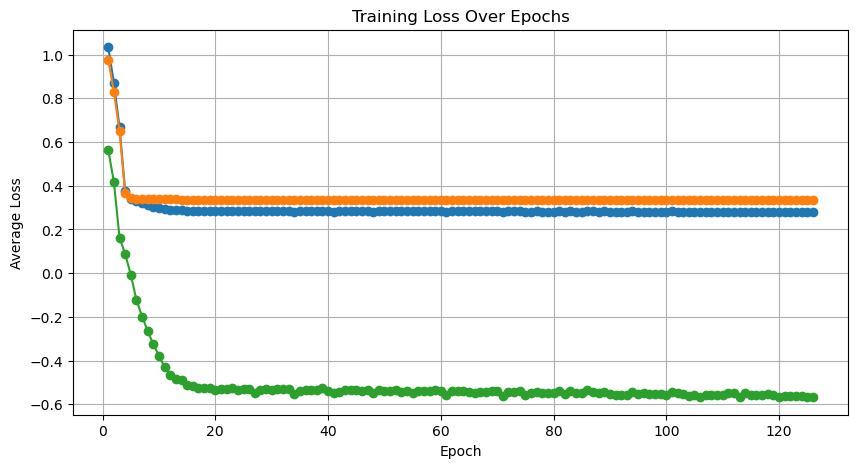

In [32]:
autoencoder_trainer = MeshAutoencoderTrainer(model = autoencoder ,warmup_steps = 10, dataset = dataset, num_train_steps=100,
                                            batch_size=8,
                                            grad_accum_every=2,
                                            learning_rate = 4e-3)
if is_train_autoencoder:
  if not is_train_autoencoder_disable_iteration:
    autoencoder_trainer.load(f'{working_dir}/mesh-encoder_{project_name}.pt')
  loss = autoencoder_trainer.train(380,stop_at_loss = 0.28, diplay_graph= True)
  autoencoder_trainer.save(f'{working_dir}/mesh-encoder_{project_name}.pt')
else:
  autoencoder_trainer.load(f'{working_dir}/mesh-encoder_{project_name}.pt')
  autencoder = autoencoder_trainer.model
  for param in autoencoder.parameters():
      param.requires_grad = True
  import gc

In [33]:
import gc
torch.cuda.empty_cache()
gc.collect()

max_length =  max(len(d["faces"]) for d in dataset if "faces" in d)
max_seq = max_length * 6
print("Highest face count:" , max_length)
print("Max token sequence:" , max_seq)

transformer = MeshTransformer(
    autoencoder,
    dim = 512,
    coarse_pre_gateloop_depth = 6, # Better performance using more gateloop layers
    fine_pre_gateloop_depth= 4,
    #attn_depth = 24, # GPT-2 medium have 24 layer depth, change if needed
    max_seq_len = max_seq,
    condition_on_text = True,
    gateloop_use_heinsen = False,
    text_condition_model_types = "bge", ## Change or remove this line if you are using:  https://github.com/MarcusLoppe/classifier-free-guidance-pytorch
    text_condition_cond_drop_prob = 0.0
)

total_params = sum(p.numel() for p in transformer.decoder.parameters())
total_params = f"{total_params / 1000000:.1f}M"
print(f"Decoder total parameters: {total_params}")
total_params = sum(p.numel() for p in transformer.parameters())
total_params = f"{total_params / 1000000:.1f}M"
print(f"Total parameters: {total_params}")

Highest face count: 3884
Max token sequence: 23304


/root/micromamba/envs/py311_meshgpt/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Decoder total parameters: 94.4M
Total parameters: 152.6M


## **Required!**, embed the text and run generate_codes to save 4-96 GB VRAM (dependant on dataset) ##

**If you don't;** <br>
During each during each training step the autoencoder will generate the codes and the text encoder will embed the text.
<br>
After these fields are generate: **they will be deleted and next time it generates the code again:**<br>

This is due to the dataloaders nature, it writes this information to a temporary COPY of the dataset


In [34]:
labels = set(item["texts"] for item in dataset.data)
print(labels)
dataset.embed_texts(transformer)
dataset.generate_codes(autoencoder)
print(dataset.data[0].keys())

{'S Bed Twin', 'S Chair Modern', 'Mire Clothing', 'S Door Double Frame', 'S Hmd', 'Sk Cat 01', 'S Stairs Single-6', 'S Table Nightstand', 'S Box', 'S Bone', 'S Table Bedside', 'S Chair Sofa Wide', 'S Door Single Frame', 'S Table Sit Rectangle', 'S Primitive Cylinder Hollow', 'S Bed King', 'S Tree No Leaves', 'S Gui', 'S Cabinet Bookshelf', 'S Ziggurat', 'S Bed Full', 'S Chair Bar', 'S Table Bar Rectangle', 'S Chair Sofa', 'S Phone', 'S Table Sit Square', 'S Chair Stool Mini', 'S Chair Box', 'S Mask', 'S Chair Stool', 'S Door Single', 'S Primitive Cylinder', 'S Primitive Pyramid', 'S Table Office', 'Sk Snake 01', 'S Primitive Sphere', 'S Table Bar Circle', 'S Cabinet Dresser 03', 'S Tree Bushy', 'S Table Bar', 'S Table Sit Circle', 'S Primitive Wedge', 'S Cabinet Dresser 05', 'S Table Counter'}
[MeshDataset] Generated 44 text_embeddings
[MeshDataset] Generated codes for 2000 entrys
dict_keys(['vertices', 'faces', 'face_edges', 'text_embeds', 'codes'])


*Load previous saved model if you had to restart session*

**Train to about 0.0001 loss (or less) if you are using a small dataset**

In [35]:
if is_train_mesh_transformer:
  trainer = MeshTransformerTrainer(model = transformer,warmup_steps = 10,grad_accum_every=4,num_train_steps=100, dataset = dataset,
                                 learning_rate = 5e-4, batch_size=1)
  loss = trainer.train(200, stop_at_loss = 0.00001)
else:
  trainer = MeshTransformerTrainer(model = transformer, warmup_steps = 10,grad_accum_every=1,num_train_steps=100, dataset = dataset, learning_rate = 1e-1, batch_size=1)
  trainer.load(f'{working_dir}/mesh-transformer_{project_name}.pt')
  transformer = trainer.model

Epoch 1/200:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1338/2000 [04:44<02:05,  5.28it/s, loss=6.7]

**Load the latest model**

In [ ]:
autoencoder_trainer = MeshAutoencoderTrainer(model = autoencoder ,warmup_steps = 10, dataset = dataset, num_train_steps=100, batch_size=1,  grad_accum_every=1, learning_rate = 1e-4)
autoencoder_trainer.load(f'{working_dir}/mesh-encoder_{project_name}.pt')
autencoder = autoencoder_trainer.model
for param in autoencoder.parameters():
    param.requires_grad = True
import gc
torch.cuda.empty_cache()
gc.collect()

max_length =  max(len(d["faces"]) for d in dataset if "faces" in d)
max_seq = max_length * 6
print("Highest face count:" , max_length)
print("Max token sequence:" , max_seq)

transformer = MeshTransformer(
    autoencoder,
    dim = 512,
    coarse_pre_gateloop_depth = 6, # Better performance using more gateloop layers
    fine_pre_gateloop_depth= 4,
    # attn_depth = 24, # GPT-2 medium have 24 layer depth, change if needed
    max_seq_len = max_seq,
    condition_on_text = True,
    gateloop_use_heinsen = False,
    text_condition_model_types = "bge", ## Change or remove this line if you are using:  https://github.com/MarcusLoppe/classifier-free-guidance-pytorch
    text_condition_cond_drop_prob = 0.0
).to("cuda")

trainer = MeshTransformerTrainer(model = transformer,warmup_steps = 10,grad_accum_every=1,num_train_steps=100, dataset = dataset, learning_rate = 1e-1, batch_size=2)
trainer.load(f'{working_dir}/mesh-transformer_{project_name}.pt')
transformer = trainer.model


## Generate and view mesh

In [ ]:
trainer.save(f'{working_dir}/mesh-transformer_{project_name}.pt')

In [ ]:
def combind_mesh(path, mesh):
    all_vertices = []
    all_faces = []
    vertex_offset = 0
    translation_distance = 0.5

    for r, faces_coordinates in enumerate(mesh):
        numpy_data = faces_coordinates[0].cpu().numpy().reshape(-1, 3)

        for vertex in numpy_data:
            all_vertices.append(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")

        for i in range(1, len(numpy_data), 3):
            all_faces.append(f"f {i + vertex_offset} {i + 1 + vertex_offset} {i + 2 + vertex_offset}\n")

        vertex_offset += len(numpy_data)

    obj_file_content = "".join(all_vertices) + "".join(all_faces)

    with open(path , "w") as file:
        file.write(obj_file_content)

def combind_mesh_with_rows(path, meshes):
    all_vertices = []
    all_faces = []
    vertex_offset = 0
    translation_distance = 0.5

    for row, mesh in enumerate(meshes):
        for r, faces_coordinates in enumerate(mesh):
            numpy_data = faces_coordinates[0].cpu().numpy().reshape(-1, 3)
            numpy_data[:, 0] += translation_distance * (r / 0.2 - 1)
            numpy_data[:, 2] += translation_distance * (row / 0.2 - 1)

            for vertex in numpy_data:
                all_vertices.append(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")

            for i in range(1, len(numpy_data), 3):
                all_faces.append(f"f {i + vertex_offset} {i + 1 + vertex_offset} {i + 2 + vertex_offset}\n")

            vertex_offset += len(numpy_data)

        obj_file_content = "".join(all_vertices) + "".join(all_faces)

    with open(path , "w") as file:
        file.write(obj_file_content)


def write_mesh_output(path, coords):
    numpy_data = faces_coordinates[0].cpu().numpy().reshape(-1, 3)
    obj_file_content = ""

    for vertex in numpy_data:
        obj_file_content += f"v {vertex[0]} {vertex[1]} {vertex[2]}\n"

    for i in range(1, len(numpy_data), 3):
        obj_file_content += f"f {i} {i + 1} {i + 2}\n"

    with open(path, "w") as file:
        file.write(obj_file_content)


**Using only text**

In [ ]:

from pathlib import Path

folder = working_dir / 'renders'
obj_file_path = Path(folder)
obj_file_path.mkdir(exist_ok = True, parents = True)

text_coords = []
for text in labels:
    print(f"Generating {text}")
    faces_coordinates = transformer.generate(texts = [text],  temperature = 0.0)
    text_coords.append(faces_coordinates)

    write_mesh_output(f'{folder}/3d_output_{text}.obj', faces_coordinates)


combind_mesh(f'{folder}/3d_models_all.obj', text_coords)

# **Preview 3d Models**

In [ ]:
!pip install ipyvolume trimesh pythreejs
import trimesh

folder = working_dir / 'renders'

mesh = trimesh.load(f'{folder}/3d_models_all.obj')
import ipyvolume as ipv

vertices = mesh.vertices
faces = mesh.faces

fig = ipv.figure()
ipv.plot_trisurf(vertices[:,0], vertices[:,1], vertices[:,2], triangles=faces)
ipv.show()

**Text + prompt of tokens**

Grab fresh copy of dataset

In [ ]:
dataset = MeshDataset.load(dataset_path)
dataset.generate_codes(autoencoder)

**Prompt with 10% of codes/tokens**

In [ ]:
from pathlib import Path
token_length_procent = 0.10
codes = []
texts = []
for label in labels:
    for item in dataset.data:
        if item['texts'] == label:
            num_tokens = int(item["codes"].shape[0] * token_length_procent)

            texts.append(item['texts'])
            codes.append(item["codes"].flatten()[:num_tokens].unsqueeze(0))
            break

folder = working_dir / f'renders/text+codes'
obj_file_path = Path(folder)
obj_file_path.mkdir(exist_ok = True, parents = True)

coords = []



for text, prompt in zip(texts, codes):
    print(f"Generating {text} with {prompt.shape[1]} tokens")
    faces_coordinates = transformer.generate(texts = [text],  prompt = prompt, temperature = 0)
    coords.append(faces_coordinates)

    obj_file_path = f'{folder}/{text}_{prompt.shape[1]}_tokens.obj'
    write_mesh_output(obj_file_path, faces_coordinates)

    print(obj_file_path)


combind_mesh(f'{folder}/text+prompt_all.obj', coords)

if text_coords is not None:
    combind_mesh_with_rows(f'{folder}/both_verisons.obj', [text_coords , coords])

**Prompt with 0% to 80% of tokens**

In [ ]:
import json
import numpy as np
import trimesh
from pathlib import Path

def convert_to_obj(vertices, faces, output_file_path):
    scene = trimesh.Scene()
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
    scene.add_geometry(mesh)

    with open(output_file_path, "w") as f:
        f.write(scene.export(file_type="obj"))

def encode_to_pua(codes):
    flat_codes = [item for sublist in codes for subsublist in sublist for item in subsublist]
    return "".join(chr(code + 0xF0000) for code in flat_codes)

jsonl_lines = []

for token_length_procent in np.arange(0, 0.8, 0.1):
    codes = []
    texts = []
    for label in labels:
        for item in dataset.data:
            if item['texts'] == label:
                num_tokens = int(item["codes"].shape[0] * token_length_procent)

                texts.append(item['texts'])
                codes.append(item["codes"].flatten()[:num_tokens].unsqueeze(0))
                break

    coords = []
    for text, code in zip(texts, codes):
        print(f"Generating {text} with {code.shape[1]} tokens")
        faces_coordinates = transformer.generate(texts=[text], prompt=code, temperature=0)
        coords.append(faces_coordinates)

        # Process mesh data inlined here
        continuous_coors_list = [np_array.tolist() for np_array in faces_coordinates]
        flat_list = [item for sublist in continuous_coors_list for item in sublist]
        vertices = [vertex for sublist in flat_list for vertex in sublist]
        faces = [[i, i + 1, i + 2] for i in range(0, len(vertices), 3)]

        obj_filename = f'{text}_{code.shape[1]}_tokens.obj'
        obj_file_path = folder / obj_filename
        convert_to_obj(vertices, faces, obj_file_path)

        encoded_codes = encode_to_pua(code.cpu().tolist())

        with open(obj_file_path, "r") as file:
            obj_contents = file.read()

        # Append line to JSONL structure
        jsonl_line = [
            {"role": "system", "content": "This assistant can understand 3D models using the meshgpt-pytorch Unicode plane 15 16384 item codebook for triangles and the .obj 3d format."},
            {"role": "user", "content": encoded_codes},
            {"role": "assistant", "content": obj_contents}
        ]
        jsonl_lines.append(jsonl_line)

        print(obj_file_path)

    mesh_rows.append(coords)
    combind_mesh(f'{folder}/text+prompt_all_{token_length_procent}.obj', coords)

combind_mesh_with_rows(f'{folder}/all.obj', mesh_rows)

with open("chatml.jsonl", "w", encoding="utf-8") as f:
    for item in jsonl_lines:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")